In [13]:
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')
import numpy as np
from common.time_layers import *
from common.optimizer import SGD
from ptb import load_data
import matplotlib.pyplot as plt
import time
# from common.trainer import RnnlmTrainer
# from simple_rnnlm import SimpleRnnlm

In [31]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [32]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

# 기울기 클리핑
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [16]:
# class RnnlmTrainer:
#     def __init__(self, model, optimizer):
#         self.model = model
#         self.optimizer = optimizer
#         self.time_idx = None
#         self.ppl_list = None
#         self.eval_interval = None
#         self.current_epoch = 0
#         self.epoch_list = []  # epoch_list 초기화

#     def get_batch(self, x, t, batch_size, time_size):
#         batch_x = np.empty((batch_size, time_size), dtype='i')
#         batch_t = np.empty((batch_size, time_size), dtype='i')

#         data_size = len(x)
#         jump = data_size // batch_size
#         offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

#         for time in range(time_size):
#             for i, offset in enumerate(offsets):
#                 batch_x[i, time] = x[(offset + self.time_idx) % data_size]
#                 batch_t[i, time] = t[(offset + self.time_idx) % data_size]
#             self.time_idx += 1
#         return batch_x, batch_t

#     def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
#             max_grad=None, eval_interval=20):
#         data_size = len(xs)
#         max_iters = data_size // (batch_size * time_size)
#         self.time_idx = 0
#         self.ppl_list = []
#         self.eval_interval = eval_interval
#         model, optimizer = self.model, self.optimizer
#         total_loss = 0
#         loss_count = 0

#         start_time = time.time()
#         for epoch in range(max_epoch):
#             for iters in range(max_iters):
#                 batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

#                 # 기울기를 구해 매개변수 갱신
#                 loss = model.forward(batch_x, batch_t)
#                 model.backward()
#                 params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
#                 if max_grad is not None:
#                     clip_grads(grads, max_grad)
#                 optimizer.update(params, grads)
#                 total_loss += loss
#                 loss_count += 1

#                 # 퍼플렉서티 평가
#                 if (eval_interval is not None) and (iters % eval_interval) == 0:
#                     ppl = np.exp(total_loss / loss_count)
#                     elapsed_time = time.time() - start_time
#                     print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
#                           % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
#                     self.ppl_list.append(float(ppl))
#                     total_loss, loss_count = 0, 0

#             self.current_epoch += 1

#     def plot(self, ylim=None):
#         x = np.arange(len(self.ppl_list))
#         if ylim is not None:
#             plt.ylim(*ylim)
#         plt.plot(x, self.ppl_list, label='train')
#         plt.xlabel('Iteration (x' + str(self.eval_interval) + ')')
#         plt.ylabel('Perplexity')
#         plt.show()

In [33]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = []
        self.eval_interval = None
        self.current_epoch = 0
        self.epoch_list = []  # epoch_list 초기화

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20, max_iters=None):
        data_size = len(xs)
        if max_iters is None:
            max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.epoch_list = []  # epoch_list 초기화
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

            # 에폭마다 퍼플렉서티 평가
            ppl = np.exp(total_loss / loss_count)
            elapsed_time = time.time() - start_time
            print('| 에폭 %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                  % (self.current_epoch + 1, elapsed_time, ppl))
            self.ppl_list.append(float(ppl))
            self.epoch_list.append(self.current_epoch + 1)
            total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.array(self.epoch_list)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('에폭')
        plt.ylabel('퍼플렉서티')
        plt.legend()
        plt.show()

In [ ]:
# # 하이퍼파라미터 설정
# batch_size = 1
# wordvec_size = 100
# hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
# time_size = 10      # Truncated BPTT가 한 번에 펼치는 시간 크기
# lr = 0.1
# max_epoch = 30

# # 다양한 corpus_size 값 설정
# corpus_size_list = [500, 1000, 3000, 5000]

# results = {}

# for corpus_size in corpus_size_list:
#     print(f"Training with corpus_size={corpus_size}...")
    
#     # 학습 데이터 읽기
#     corpus, word_to_id, id_to_word = load_data('train')
#     corpus = corpus[:corpus_size]
#     vocab_size = int(max(corpus) + 1)
#     xs = corpus[:-1]  # 입력
#     ts = corpus[1:]  # 출력（정답 레이블）

#     # 모델 생성
#     model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
#     optimizer = SGD(lr)
#     trainer = RnnlmTrainer(model, optimizer)

#     # 학습
#     trainer.fit(xs, ts, max_epoch, batch_size, time_size)
    
#     # 결과 저장
#     results[corpus_size] = trainer.ppl_list

# # 그래프 그리기
# plt.figure(figsize=(12, 8))
# for corpus_size, ppl_list in results.items():
#     x = np.arange(1, len(ppl_list) + 1)
#     plt.plot(x, ppl_list, marker='o', label=f'corpus_size={corpus_size}')

# plt.xlabel('Epochs')
# plt.ylabel('Perplexity')
# plt.legend()
# plt.show()

Training with time_size=5...
| 에폭 1 | 시간 10[s] | 퍼플렉서티 443.42
| 에폭 2 | 시간 19[s] | 퍼플렉서티 296.86
| 에폭 3 | 시간 29[s] | 퍼플렉서티 229.67
| 에폭 4 | 시간 39[s] | 퍼플렉서티 185.94
| 에폭 5 | 시간 48[s] | 퍼플렉서티 147.22
| 에폭 6 | 시간 57[s] | 퍼플렉서티 118.02
| 에폭 7 | 시간 67[s] | 퍼플렉서티 102.34
| 에폭 8 | 시간 77[s] | 퍼플렉서티 87.76
| 에폭 9 | 시간 86[s] | 퍼플렉서티 78.09
| 에폭 10 | 시간 96[s] | 퍼플렉서티 68.22
Training with time_size=10...
| 에폭 1 | 시간 8[s] | 퍼플렉서티 459.35
| 에폭 2 | 시간 16[s] | 퍼플렉서티 334.92
| 에폭 3 | 시간 24[s] | 퍼플렉서티 285.33
| 에폭 4 | 시간 32[s] | 퍼플렉서티 241.63
| 에폭 5 | 시간 37[s] | 퍼플렉서티 212.44
| 에폭 6 | 시간 43[s] | 퍼플렉서티 178.87
| 에폭 7 | 시간 49[s] | 퍼플렉서티 165.27
| 에폭 8 | 시간 54[s] | 퍼플렉서티 142.34
| 에폭 9 | 시간 60[s] | 퍼플렉서티 122.74
| 에폭 10 | 시간 66[s] | 퍼플렉서티 107.70
Training with time_size=20...
| 에폭 1 | 시간 5[s] | 퍼플렉서티 468.85
| 에폭 2 | 시간 11[s] | 퍼플렉서티 360.87
| 에폭 3 | 시간 17[s] | 퍼플렉서티 327.93
| 에폭 4 | 시간 22[s] | 퍼플렉서티 307.61
| 에폭 5 | 시간 28[s] | 퍼플렉서티 296.14
| 에폭 6 | 시간 33[s] | 퍼플렉서티 272.25
| 에폭 7 | 시간 38[s] | 퍼플렉서티 250.45
| 에폭 8 | 시간 44[s] | 퍼플렉

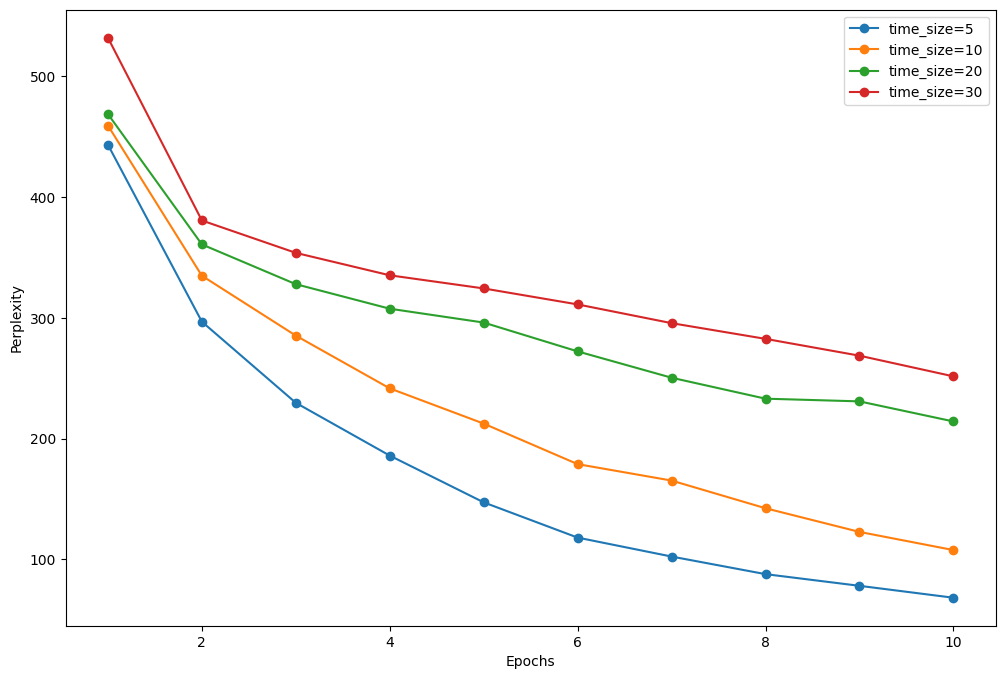

In [43]:
# 하이퍼파라미터 설정
batch_size = 1
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
lr = 0.1
max_epoch = 10

# 다양한 time_size 값 설정
time_size_list = [5, 10, 20, 30]

results = {}

# 반복문을 활용해 time_size를 바꿔가며 RNN 학습 및 퍼플렉시티 결과 시각화
for time_size in time_size_list:
    print(f"Training with time_size={time_size}...")
    
    # 학습 데이터 읽기
    corpus, word_to_id, id_to_word = load_data('train')
    corpus_size = 5000  # 고정된 corpus_size 사용
    corpus = corpus[:corpus_size]
    vocab_size = int(max(corpus) + 1)
    xs = corpus[:-1]  # 입력
    ts = corpus[1:]  # 출력（정답 레이블）

    # 모델 생성
    model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
    optimizer = SGD(lr)
    trainer = RnnlmTrainer(model, optimizer)

    # 학습
    trainer.fit(xs, ts, max_epoch, batch_size, time_size)
    
    # 결과 저장
    results[time_size] = trainer.ppl_list

# 그래프 그리기
plt.figure(figsize=(12, 8))
for time_size, ppl_list in results.items():
    x = np.arange(1, len(ppl_list) + 1)
    plt.plot(x, ppl_list, marker='o', label=f'time_size={time_size}')

plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()